# motion-sense
- link: https://github.com/mmalekzadeh/motion-sense?tab=readme-ov-file
- iPhone 6s의 Core Motion - DeviceMotion 신호 사용
- Sampling Rate: 50Hz
- 기기 위치: 피험자 바지 앞 주머니
- 피험자 수: 24명
- Label
    1. `dws`: downstairs
    2. `ups`: upstairs
    3. `sit`: sitting
    4. `std`: standing
    5. `wlk`: walking
    6. `jog`: jogging
- 피험자가 6가지 활동을 여러 Trial로 수행
    - `1~9`: Long trial (2~3분)
    - `11~16`: Short trial (30초~1분)

---
- download: `git clone https://github.com/mmalekzadeh/motion-sense.git`
- data 폴더에는 3가지 종류 존재
    1. `A_DeviceMotion_data`
    2. `B_Accelerometer_data`: 순수 accel(x/y/z)만
    3. `C_Gyroscope_data`: 순수 gyro(x/y/z)만
- 대부분의 논문은 `A_DeviceMotion_data`만 사용(README에서 보통은 (A)만 쓰면 된다고 설명도 적혀있다.)
    - iPhone의 DeviceMotion에서 나온 것
    - `attitude`(roll, pitch, yaw) - orientation
    - `gravity` - 중력 성분
    - `rotationRate` - Gyro
    - `userAcceleration` - 사용자가 준 가속도
```text
A_DeviceMotion_data/
  dws_1/
    sub_1.csv
    sub_2.csv
    ...
  dws_2/
  dws_11/
  jog_9/
  ...
```
- `data_subjects_info`: subject에 대한 정보가 필요할 때 사용
---

In [3]:
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/HAR_data/motion-sense"

A_ROOT = f"{DATA_ROOT}/A_DeviceMotion_data"
SUBJECT_INFO = f"{DATA_ROOT}/data_subjects_info.csv"

In [4]:
from tqdm import tqdm
import os
import glob
import pandas as pd
import numpy as np

def build_metadata(a_root, fs=50.0):
    file_paths = sorted(glob.glob(os.path.join(a_root, "*", "sub_*.csv")))
    records = []

    for path in tqdm(file_paths):
        # .../A_DeviceMotion_data/dws_1/sub_3.csv
        folder = os.path.basename(os.path.dirname(path))   # dws_1
        act_code, trial_str = folder.split("_")           # 'dws', '1'
        trial = int(trial_str)

        fname = os.path.basename(path)                    # sub_3.csv
        subject = int(fname.replace("sub_", "").replace(".csv", ""))

        df = pd.read_csv(path)
        n_samples = len(df)
        duration_sec = n_samples / fs

        records.append({
            "activity_code": act_code,
            "trial": trial,
            "subject": subject,
            "n_samples": n_samples,
            "duration_sec": duration_sec,
            "path": path,
        })

    meta = pd.DataFrame(records)

    # 활동 코드 → 사람이 보기 좋은 이름으로 매핑
    activity_map = {
        "dws": "downstairs",
        "ups": "upstairs",
        "sit": "sitting",
        "std": "standing",
        "wlk": "walking",
        "jog": "jogging",
    }
    meta["activity"] = meta["activity_code"].map(activity_map)

    return meta

meta = build_metadata(A_ROOT)
meta.head()

100%|██████████| 360/360 [01:46<00:00,  3.38it/s]


,activity_code,trial,subject,n_samples,duration_sec,path,activity
0,dws,1,1,1751,35.02,/content/drive/MyDrive/Colab Notebooks/HAR_dat...,downstairs
1,dws,1,10,2678,53.56,/content/drive/MyDrive/Colab Notebooks/HAR_dat...,downstairs
2,dws,1,11,2025,40.50,/content/drive/MyDrive/Colab Notebooks/HAR_dat...,downstairs
3,dws,1,12,1522,30.44,/content/drive/MyDrive/Colab Notebooks/HAR_dat...,downstairs
4,dws,1,13,1583,31.66,/content/drive/MyDrive/Colab Notebooks/HAR_dat...,downstairs


In [5]:
print("총 시퀀스 개수 :", len(meta))
print("고유 subject 수 :", meta['subject'].nunique())
print("활동별 시퀀스 수")
print(meta['activity'].value_counts())

print("\n트라이얼 코드 분포")
print(meta['trial'].value_counts().sort_index())

print("\n시퀀스 길이(초) 통계")
print(meta['duration_sec'].describe())


총 시퀀스 개수 : 360
고유 subject 수 : 24
활동별 시퀀스 수
activity
downstairs    72
walking       72
upstairs      72
jogging       48
standing      48
sitting       48
Name: count, dtype: int64

트라이얼 코드 분포
trial
1     24
2     24
3     24
4     24
5     24
6     24
7     24
8     24
9     24
11    24
12    24
13    24
14    24
15    24
16    24
Name: count, dtype: int64

시퀀스 길이(초) 통계
count    360.000000
mean      78.492500
std       56.910223
min        7.540000
25%       38.015000
50%       58.970000
75%      103.560000
max      328.480000
Name: duration_sec, dtype: float64


In [6]:
# 활동별 총 duration
duration_by_act = meta.groupby("activity")["duration_sec"].sum().sort_values(ascending=False)
print(duration_by_act)

# subject별 총 duration
duration_by_subj = meta.groupby("subject")["duration_sec"].sum()
print("\nsubject별 총 길이(초)")
print(duration_by_subj.describe())


activity
walking       6885.76
sitting       6775.56
standing      6128.54
upstairs      3145.70
jogging       2684.62
downstairs    2637.12
Name: duration_sec, dtype: float64

subject별 총 길이(초)
count      24.000000
mean     1177.387500
std       105.932005
min      1020.100000
25%      1108.850000
50%      1166.200000
75%      1246.375000
max      1438.980000
Name: duration_sec, dtype: float64


In [7]:
sample_path = meta.iloc[0]["path"]
sample_df = pd.read_csv(sample_path)
print(sample_df.columns.tolist())

['Unnamed: 0', 'attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']


In [8]:
ACC_COLS = [
    "userAcceleration.x",
    "userAcceleration.y",
    "userAcceleration.z",
]

GYRO_COLS = [
    "rotationRate.x",
    "rotationRate.y",
    "rotationRate.z",
]

FEATURE_COLS = ACC_COLS + GYRO_COLS
FEATURE_COLS

['userAcceleration.x',
 'userAcceleration.y',
 'userAcceleration.z',
 'rotationRate.x',
 'rotationRate.y',
 'rotationRate.z']

In [22]:
# 샘플 하나만 빠르게 확인
sample_path = meta.iloc[0]["path"]
sample_df = pd.read_csv(sample_path)

print("샘플 파일 결측치 개수:")
print(sample_df[FEATURE_COLS].isna().sum())
print("총 결측치:", sample_df[FEATURE_COLS].isna().sum().sum())

샘플 파일 결측치 개수:
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
dtype: int64
총 결측치: 0


In [23]:
from tqdm import tqdm
import pandas as pd

def check_missing_over_all(meta, feature_cols):
    total_missing = 0
    col_missing = {col: 0 for col in feature_cols}

    for _, row in tqdm(meta.iterrows(), total=len(meta)):
        df = pd.read_csv(row["path"])

        na = df[feature_cols].isna()
        total_missing += na.sum().sum()

        col_missing = {
            col: col_missing[col] + na[col].sum()
            for col in feature_cols
        }

    return total_missing, col_missing

total_missing, col_missing = check_missing_over_all(meta, FEATURE_COLS)

print("전체 결측치 개수:", total_missing)
print("컬럼별 결측치 개수:")
for k, v in col_missing.items():
    print(f"  {k}: {v}")

100%|██████████| 360/360 [00:04<00:00, 73.27it/s]

전체 결측치 개수: 0
컬럼별 결측치 개수:
  userAcceleration.x: 0
  userAcceleration.y: 0
  userAcceleration.z: 0
  rotationRate.x: 0
  rotationRate.y: 0
  rotationRate.z: 0


In [24]:
# 랜덤하게 몇 개의 시퀀스를 뽑아서 분포 보기
n_samples = min(80, len(meta))  # 최대 80개 시퀀스
sample_paths = meta["path"].sample(n=n_samples, random_state=42).tolist()

dfs = []
for path in sample_paths:
    df = pd.read_csv(path)
    dfs.append(df[FEATURE_COLS])

all_feat = pd.concat(dfs, ignore_index=True)  # (총길이, 6채널)

all_feat.head()

,userAcceleration.x,userAcceleration.y,userAcceleration.z,rotationRate.x,rotationRate.y,rotationRate.z
0,-0.367127,-0.326563,0.015140,-1.439003,0.871748,-0.385910
1,-0.551529,-0.232497,0.238273,-1.862190,2.202111,-1.042186
2,-0.452121,0.111132,0.248192,-2.144634,2.914732,-1.583456
3,-0.381713,0.396078,0.258335,-1.828574,2.773814,-1.781894
4,-0.049819,0.537289,0.214418,-1.164304,2.144423,-1.605532


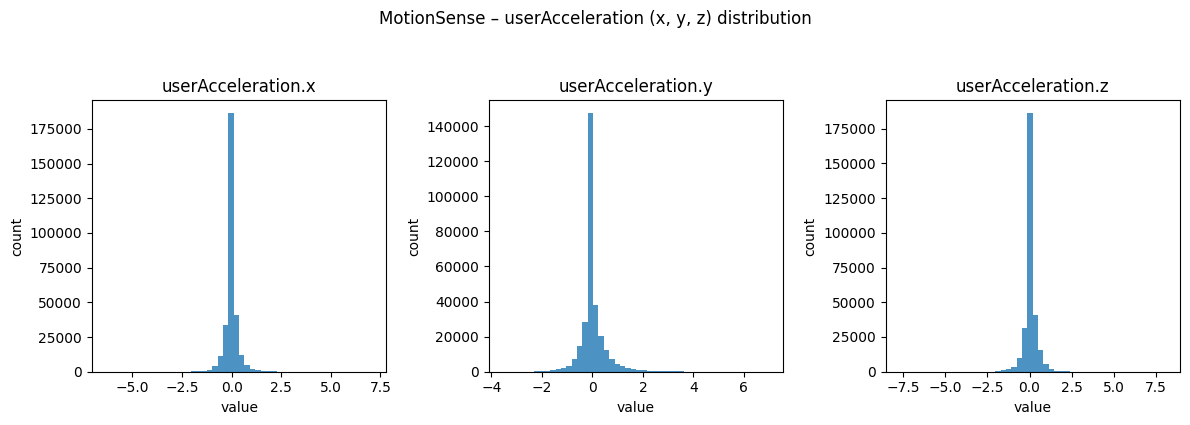

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

for i, col in enumerate(ACC_COLS):
    plt.subplot(1, 3, i+1)
    plt.hist(all_feat[col], bins=50, alpha=0.8)
    plt.title(col)
    plt.xlabel("value")
    plt.ylabel("count")

plt.suptitle("MotionSense – userAcceleration (x, y, z) distribution", y=1.05)
plt.tight_layout()
plt.show()

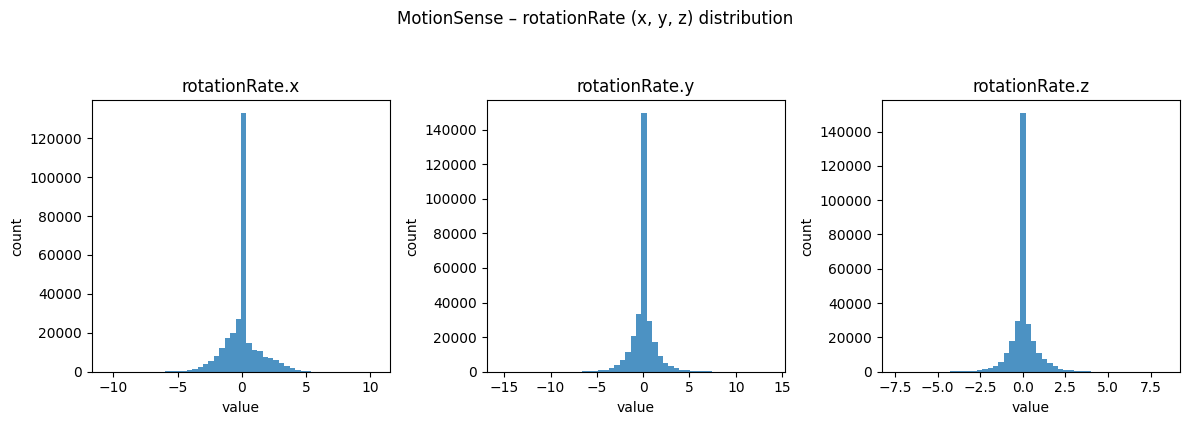

In [27]:
plt.figure(figsize=(12, 4))

for i, col in enumerate(GYRO_COLS):
    plt.subplot(1, 3, i+1)
    plt.hist(all_feat[col], bins=50, alpha=0.8)
    plt.title(col)
    plt.xlabel("value")
    plt.ylabel("count")

plt.suptitle("MotionSense – rotationRate (x, y, z) distribution", y=1.05)
plt.tight_layout()
plt.show()

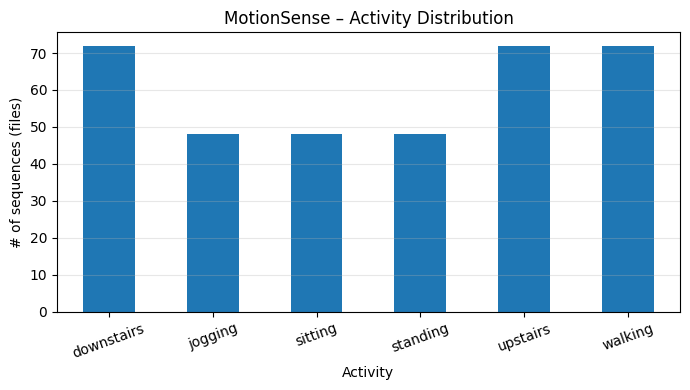

activity
downstairs    72
jogging       48
sitting       48
standing      48
upstairs      72
walking       72
Name: count, dtype: int64


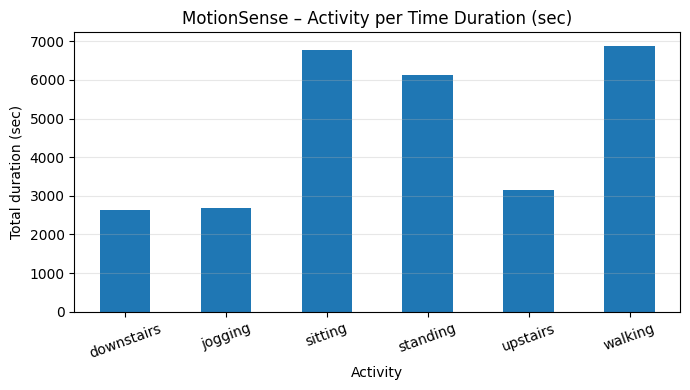

activity
downstairs    2637.12
jogging       2684.62
sitting       6775.56
standing      6128.54
upstairs      3145.70
walking       6885.76
Name: duration_sec, dtype: float64


In [29]:
# 1) 활동별 시퀀스 개수
counts = meta["activity"].value_counts().sort_index()

plt.figure(figsize=(7, 4))
counts.plot(kind="bar")
plt.title("MotionSense – Activity Distribution")
plt.xlabel("Activity")
plt.ylabel("# of sequences (files)")
plt.xticks(rotation=20)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(counts)

# 2) 활동별 총 duration (초)
dur_per_act = meta.groupby("activity")["duration_sec"].sum().sort_index()

plt.figure(figsize=(7, 4))
dur_per_act.plot(kind="bar")
plt.title("MotionSense – Activity per Time Duration (sec)")
plt.xlabel("Activity")
plt.ylabel("Total duration (sec)")
plt.xticks(rotation=20)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(dur_per_act)

jogging: 100%|██████████| 48/48 [00:00<00:00, 81.16it/s]
/tmp/ipython-input-3301433061.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=activities, showfliers=False)


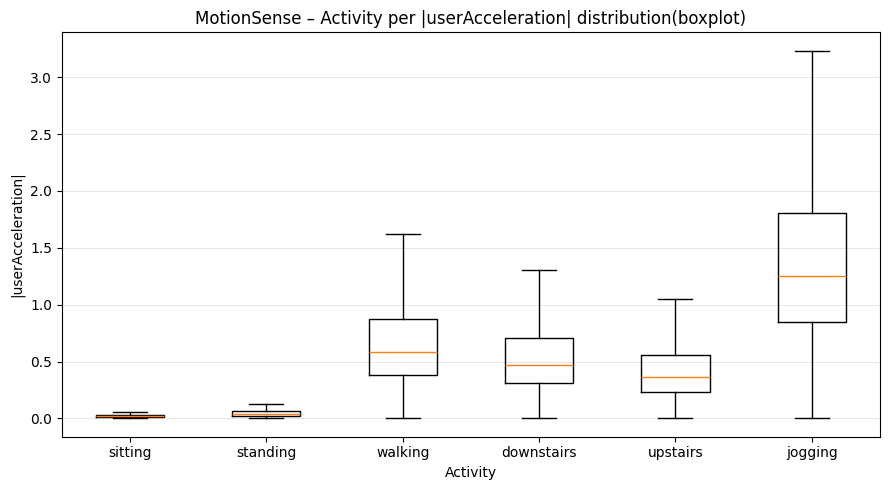

In [31]:
FS = 50.0
activities = ["sitting", "standing", "walking", "downstairs", "upstairs", "jogging"]

acc_mag_by_act = {act: [] for act in activities}

# 각 activity별로 여러 시퀀스에서 acc magnitude 수집
for act in activities:
    sub_meta = meta[meta["activity"] == act]

    for _, row in tqdm(sub_meta.iterrows(), total=len(sub_meta), desc=f"{act}"):
        df = pd.read_csv(row["path"])
        acc = df[ACC_COLS].to_numpy()
        acc_mag = np.linalg.norm(acc, axis=1)  # (T,)
        acc_mag_by_act[act].append(acc_mag)

# 리스트를 concat해서 1D로
for act in activities:
    if len(acc_mag_by_act[act]) > 0:
        acc_mag_by_act[act] = np.concatenate(acc_mag_by_act[act], axis=0)

# 박스플롯
plt.figure(figsize=(9, 5))
data = [acc_mag_by_act[act] for act in activities]
plt.boxplot(data, labels=activities, showfliers=False)
plt.title("MotionSense – Activity per |userAcceleration| distribution(boxplot)")
plt.xlabel("Activity")
plt.ylabel("|userAcceleration|")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

activity                                              walking
trial                                                      15
subject                                                     1
path        /content/drive/MyDrive/Colab Notebooks/HAR_dat...
Name: 288, dtype: object


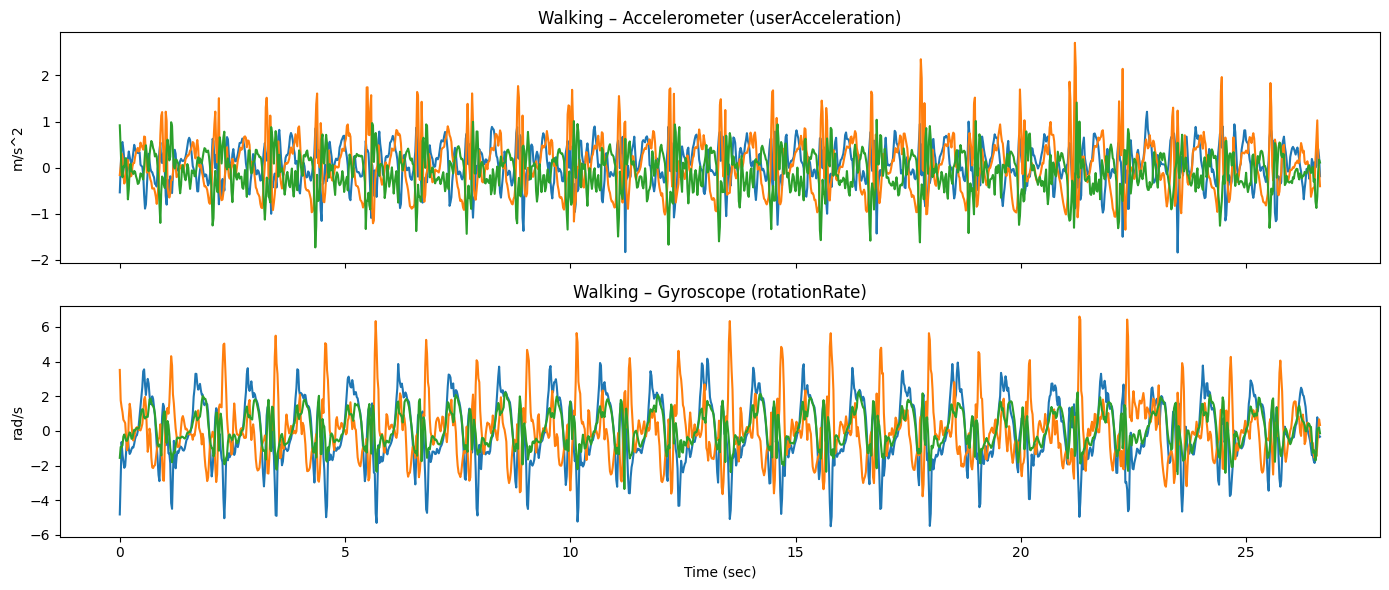

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FS = 50.0  # MotionSense 샘플링 주파수

# 1) walking 중에서 첫 번째 시퀀스 가져오기
sample_row = meta[meta["activity"] == "walking"].iloc[0]
print(sample_row[["activity", "trial", "subject", "path"]])

df = pd.read_csv(sample_row["path"])

# 2) 우리가 쓸 6채널만 추출
feat = df[FEATURE_COLS].copy()

# 3) 시간축 (초 단위)
t = np.arange(len(feat)) / FS

# 4) acc / gyro 각각 그리기
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

axes[0].plot(t, feat[ACC_COLS])
axes[0].set_title("Walking – Accelerometer (userAcceleration)")
axes[0].set_ylabel("m/s^2")

axes[1].plot(t, feat[GYRO_COLS])
axes[1].set_title("Walking – Gyroscope (rotationRate)")
axes[1].set_ylabel("rad/s")
axes[1].set_xlabel("Time (sec)")

plt.tight_layout()
plt.show()

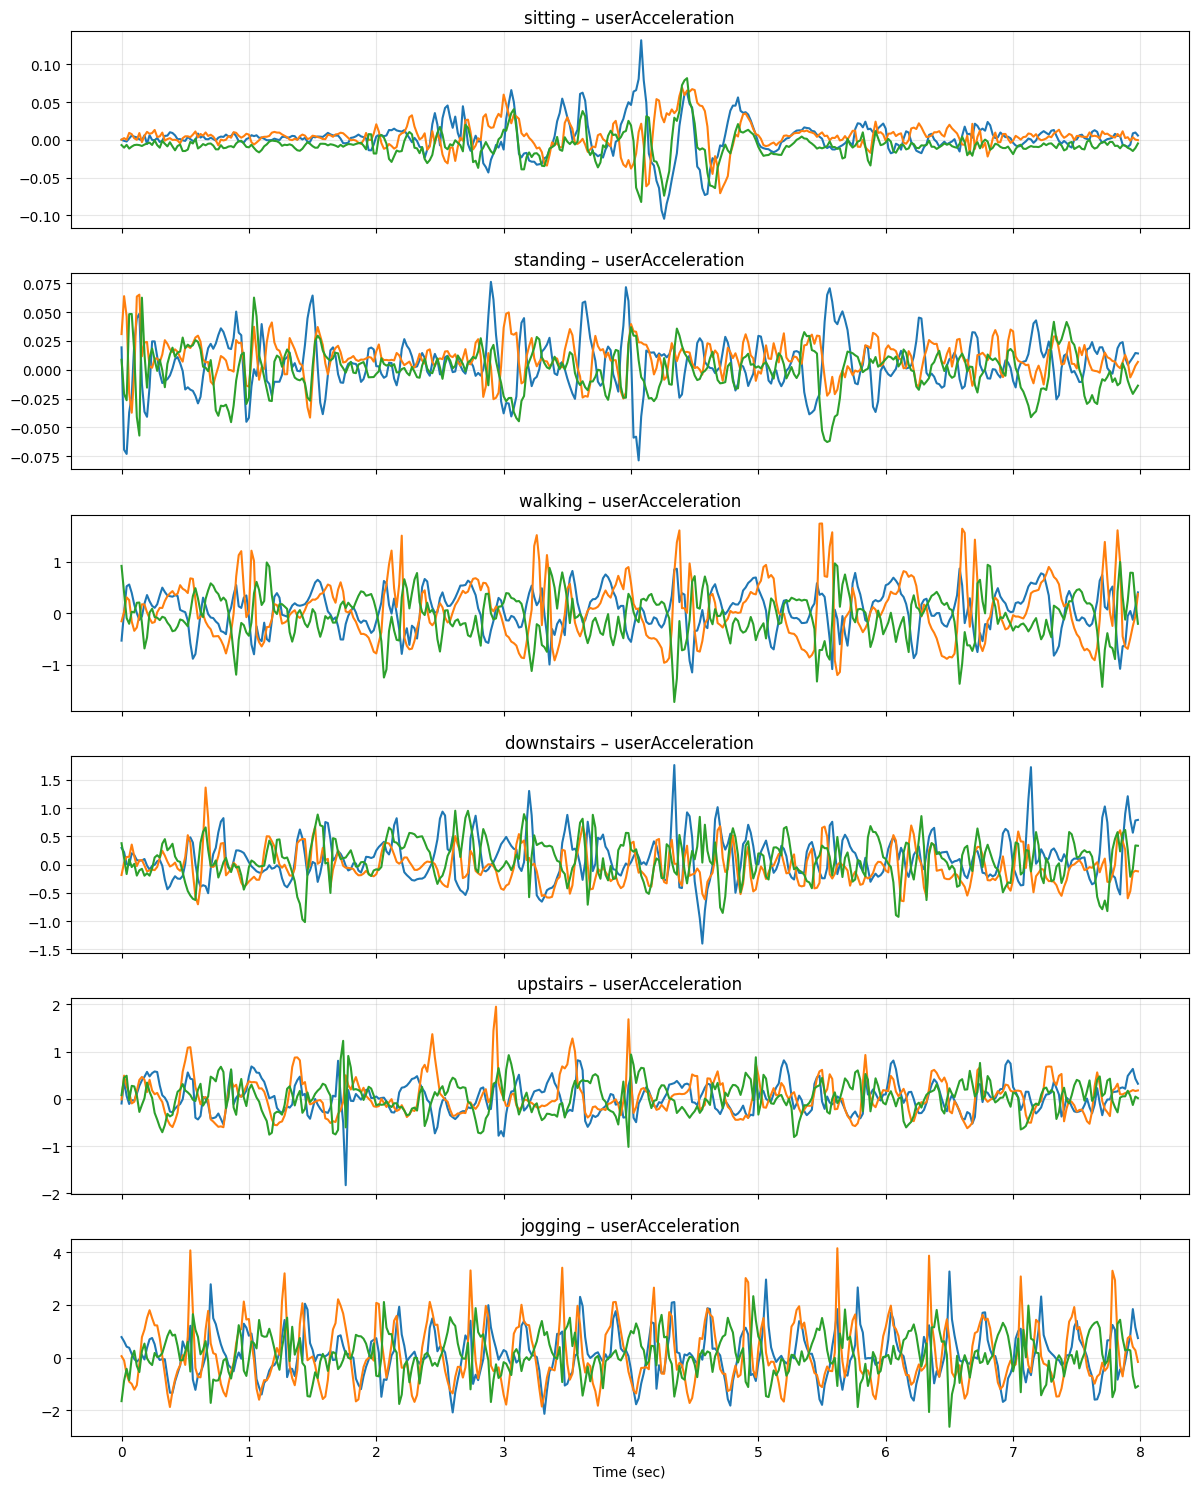

In [20]:
activities = ["sitting", "standing", "walking", "downstairs", "upstairs", "jogging"]
FS = 50.0

max_seconds = 8  # 앞에서 8초만 보기
max_len = int(max_seconds * FS)

fig, axes = plt.subplots(len(activities), 1, figsize=(12, 2.5 * len(activities)), sharex=True)

for i, act in enumerate(activities):
    row = meta[meta["activity"] == act].iloc[0]
    df = pd.read_csv(row["path"])

    acc = df[ACC_COLS].iloc[:max_len]
    t = np.arange(len(acc)) / FS

    ax = axes[i]
    for col in ACC_COLS:
        ax.plot(t, acc[col], label=col)

    ax.set_title(f"{act} – userAcceleration")
    ax.grid(True, alpha=0.3)
    if i == len(activities) - 1:
        ax.set_xlabel("Time (sec)")

fig.tight_layout()
plt.show()

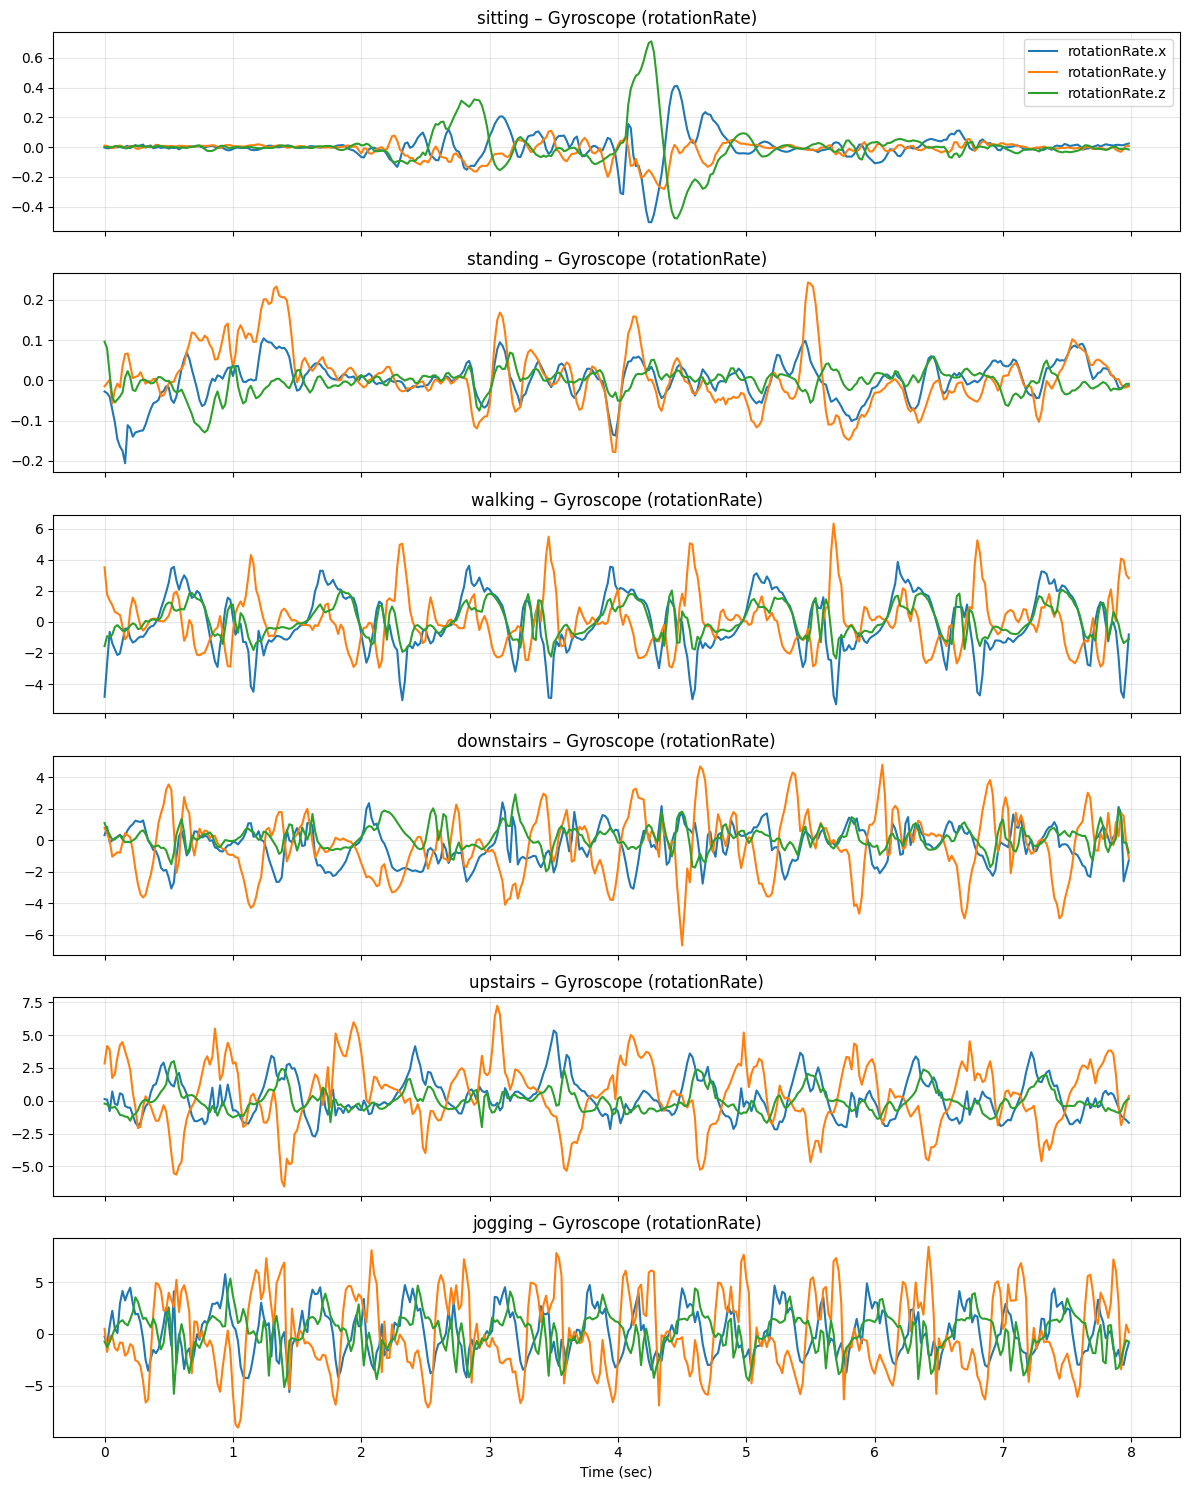

In [21]:
FS = 50.0  # Hz
activities = ["sitting", "standing", "walking", "downstairs", "upstairs", "jogging"]

max_seconds = 8          # 앞에서 8초만 보기
max_len = int(max_seconds * FS)

fig, axes = plt.subplots(len(activities), 1, figsize=(12, 2.5 * len(activities)), sharex=True)

for i, act in enumerate(activities):
    row = meta[meta["activity"] == act].iloc[0]
    df = pd.read_csv(row["path"])

    gyro = df[GYRO_COLS].iloc[:max_len]   # rotationRate.x, y, z
    t = np.arange(len(gyro)) / FS

    ax = axes[i]
    for col in GYRO_COLS:
        ax.plot(t, gyro[col], label=col)

    ax.set_title(f"{act} – Gyroscope (rotationRate)")
    ax.grid(True, alpha=0.3)

    # 맨 위 subplot에만 legend 달기
    if i == 0:
        ax.legend()

    if i == len(activities) - 1:
        ax.set_xlabel("Time (sec)")

fig.tight_layout()
plt.show()

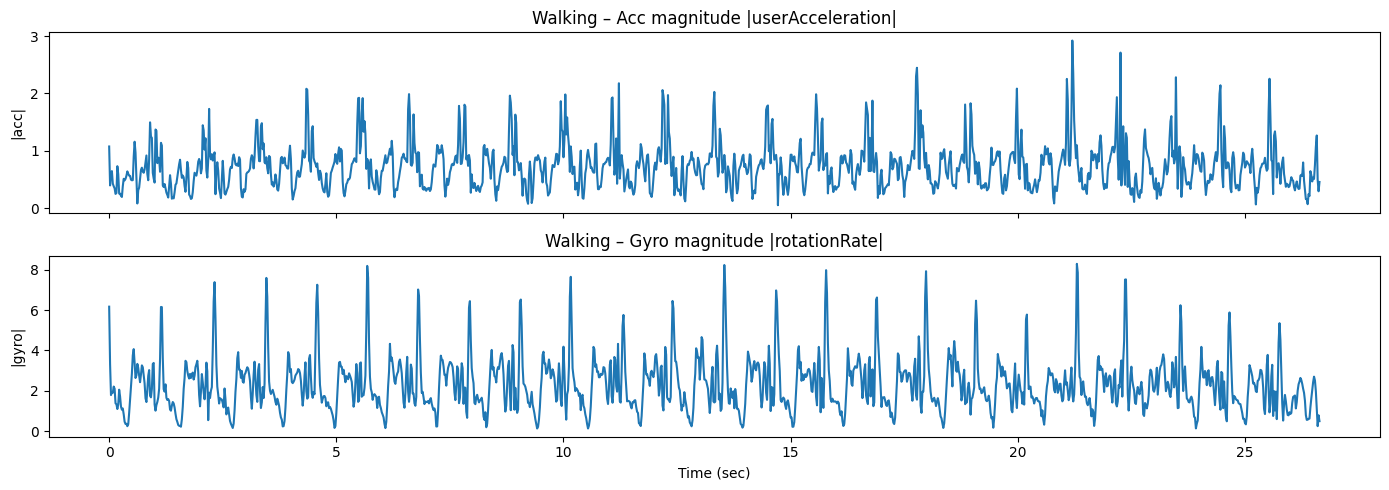

In [10]:
acc = feat[ACC_COLS].to_numpy()
gyro = feat[GYRO_COLS].to_numpy()

acc_mag = np.linalg.norm(acc, axis=1)   # sqrt(x^2 + y^2 + z^2)
gyro_mag = np.linalg.norm(gyro, axis=1)

fig, axes = plt.subplots(2, 1, figsize=(14, 5), sharex=True)

axes[0].plot(t, acc_mag)
axes[0].set_title("Walking – Acc magnitude |userAcceleration|")
axes[0].set_ylabel("|acc|")

axes[1].plot(t, gyro_mag)
axes[1].set_title("Walking – Gyro magnitude |rotationRate|")
axes[1].set_ylabel("|gyro|")
axes[1].set_xlabel("Time (sec)")

plt.tight_layout()
plt.show()

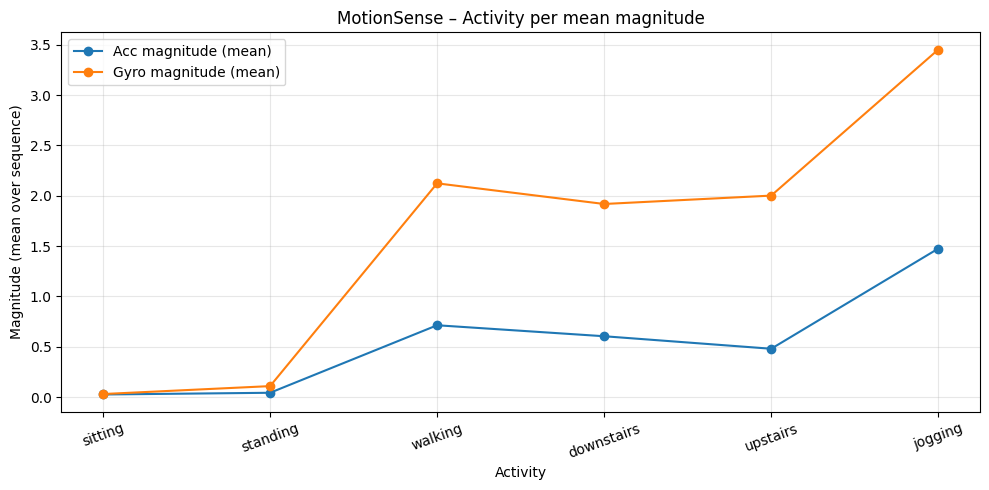

In [19]:
act_order = ["sitting", "standing", "walking", "downstairs", "upstairs", "jogging"]

mean_by_act = (
    trial_stats
    .groupby("activity")[["acc_mag_mean", "gyro_mag_mean"]]
    .mean()
    .loc[act_order]
)

plt.figure(figsize=(10, 5))

plt.plot(mean_by_act.index, mean_by_act["acc_mag_mean"], marker="o", label="Acc magnitude (mean)")
plt.plot(mean_by_act.index, mean_by_act["gyro_mag_mean"], marker="o", label="Gyro magnitude (mean)")

plt.title("MotionSense – Activity per mean magnitude")
plt.xlabel("Activity")
plt.ylabel("Magnitude (mean over sequence)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [11]:
from tqdm import tqdm

def compute_trial_stats(meta, acc_cols, gyro_cols):
    rows = []

    for _, row in tqdm(meta.iterrows(), total=len(meta)):
        df = pd.read_csv(row["path"])
        acc = df[acc_cols].to_numpy()
        gyro = df[gyro_cols].to_numpy()

        acc_mag = np.linalg.norm(acc, axis=1)
        gyro_mag = np.linalg.norm(gyro, axis=1)

        rows.append({
            "activity": row["activity"],
            "activity_code": row["activity_code"],
            "subject": row["subject"],
            "trial": row["trial"],
            "acc_mag_mean": acc_mag.mean(),
            "acc_mag_std": acc_mag.std(),
            "gyro_mag_mean": gyro_mag.mean(),
            "gyro_mag_std": gyro_mag.std(),
        })

    return pd.DataFrame(rows)

trial_stats = compute_trial_stats(meta, ACC_COLS, GYRO_COLS)
trial_stats.head()

100%|██████████| 360/360 [00:04<00:00, 73.10it/s]


,activity,activity_code,subject,trial,acc_mag_mean,acc_mag_std,gyro_mag_mean,gyro_mag_std
0,downstairs,dws,1,1,0.501065,0.262692,2.050740,1.219112
1,downstairs,dws,10,1,0.412475,0.260857,1.356675,0.727803
2,downstairs,dws,11,1,0.496910,0.295093,1.804294,0.926291
3,downstairs,dws,12,1,0.920886,0.597693,2.542101,1.265590
4,downstairs,dws,13,1,0.706560,0.432263,2.101499,1.039070


In [12]:
trial_stats.groupby("activity")[["acc_mag_mean", "gyro_mag_mean"]].describe()

acc_mag_mean                                                    \
                  count      mean       std       min       25%       50%   
activity                                                                    
downstairs         72.0  0.603726  0.170400  0.366676  0.485549  0.546084   
jogging            48.0  1.474341  0.309135  0.939635  1.209059  1.485407   
sitting            48.0  0.024962  0.023326  0.007415  0.015374  0.018785   
standing           48.0  0.042132  0.019603  0.011524  0.028473  0.039367   
upstairs           72.0  0.479473  0.173391  0.233911  0.368920  0.448092   
walking            72.0  0.712863  0.182170  0.368629  0.570077  0.714774   

                               gyro_mag_mean                                \
                 75%       max         count      mean       std       min   
activity                                                                     
downstairs  0.696697  1.166237          72.0  1.917690  0.551770  0.942447   
jogging     1.697191  2.141190          48.0  3.451719  0.910855  1.604114   
sitting     0.026193  0.134033          48.0  0.029543  0.015800  0.005706   
standing    0.051564  0.092461          48.0  0.108235  0.056132  0.032137   
upstairs    0.528349  1.024739          72.0  2.001003  0.580036  0.888390   
walking     0.810367  1.351772          72.0  2.122802  0.516675  0.913067   

                                                    
                 25%       50%       75%       max  
activity                                            
downstairs  1.522179  1.863033  2.185780  3.273320  
jogging     2.798470  3.523986  4.125395  5.104989  
sitting     0.019437  0.024910  0.035492  0.075637  
standing    0.070239  0.089282  0.139512  0.314052  
upstairs    1.688522  2.040398  2.291741  3.395428  
walking     1.849377  2.218582  2.477082  2.961994

<Axes: xlabel='activity'>

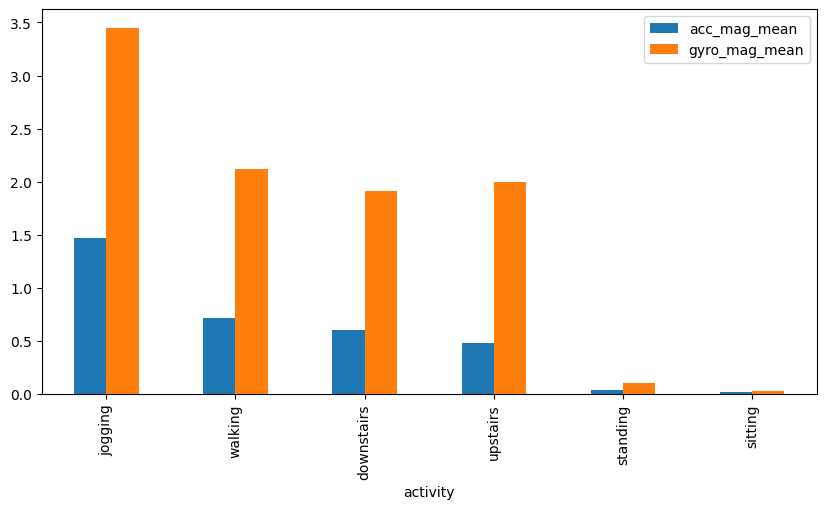

In [14]:
mean_by_act = trial_stats.groupby("activity")[["acc_mag_mean", "gyro_mag_mean"]].mean()

mean_by_act.sort_values("acc_mag_mean", ascending=False).plot(
    kind="bar", figsize=(10, 5)
)

In [33]:
# 시퀀스 개수 기준 (파일 개수)
sub_act_counts = meta.pivot_table(
    index="subject",
    columns="activity",
    values="path",      # 그냥 아무 컬럼이나 count용으로
    aggfunc="count",
    fill_value=0,
)

print(sub_act_counts)

activity  downstairs  jogging  sitting  standing  upstairs  walking
subject                                                            
1                  3        2        2         2         3        3
2                  3        2        2         2         3        3
3                  3        2        2         2         3        3
4                  3        2        2         2         3        3
5                  3        2        2         2         3        3
6                  3        2        2         2         3        3
7                  3        2        2         2         3        3
8                  3        2        2         2         3        3
9                  3        2        2         2         3        3
10                 3        2        2         2         3        3
11                 3        2        2         2         3        3
12                 3        2        2         2         3        3
13                 3        2        2         2

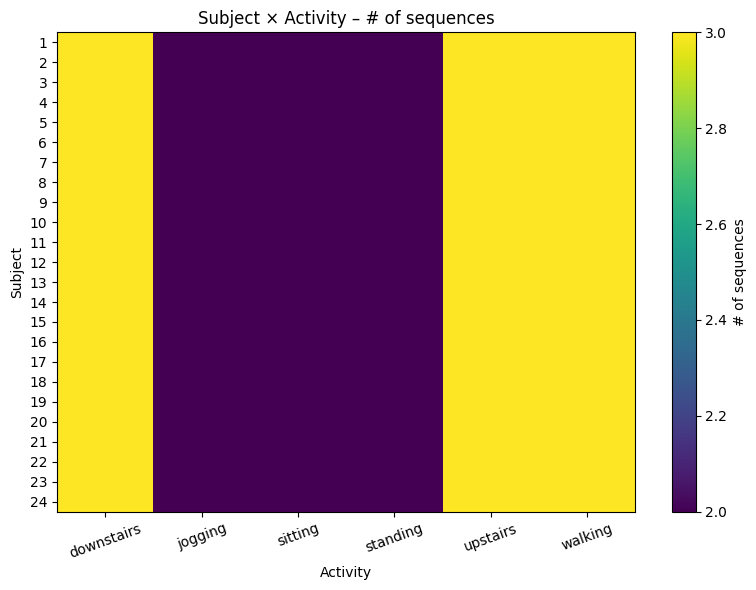

In [34]:
plt.figure(figsize=(8, 6))
plt.imshow(sub_act_counts, aspect="auto")
plt.colorbar(label="# of sequences")
plt.xticks(range(len(sub_act_counts.columns)), sub_act_counts.columns, rotation=20)
plt.yticks(range(len(sub_act_counts.index)), sub_act_counts.index)
plt.title("Subject × Activity – # of sequences")
plt.xlabel("Activity")
plt.ylabel("Subject")
plt.tight_layout()
plt.show()

In [35]:
sub_act_dur = meta.pivot_table(
    index="subject",
    columns="activity",
    values="duration_sec",
    aggfunc="sum",
    fill_value=0,
)

print(sub_act_dur)

activity  downstairs  jogging  sitting  standing  upstairs  walking
subject                                                            
1             102.10   128.56   411.68    254.94    126.72   222.24
2             117.56   128.36   258.64    205.52    144.70   392.00
3             126.48   119.38   283.94    286.14    131.16   303.96
4             101.72   124.30   243.36    211.30    129.14   311.50
5             100.98    86.46   278.10    248.36    111.52   220.24
6             114.94   105.44   237.00    287.00    107.72   294.46
7             100.70   117.98   326.02    237.70    149.04   294.08
8             115.68   123.98   287.54    273.34    142.60   271.40
9             109.96    98.38   324.12    196.58    129.84   283.84
10            133.52   117.00   305.22    208.28    136.50   295.40
11            114.72    85.38   311.52    285.32    126.00   262.90
12             84.78   115.56   219.68    230.72    130.80   284.32
13             78.98    88.86   263.50    315.36

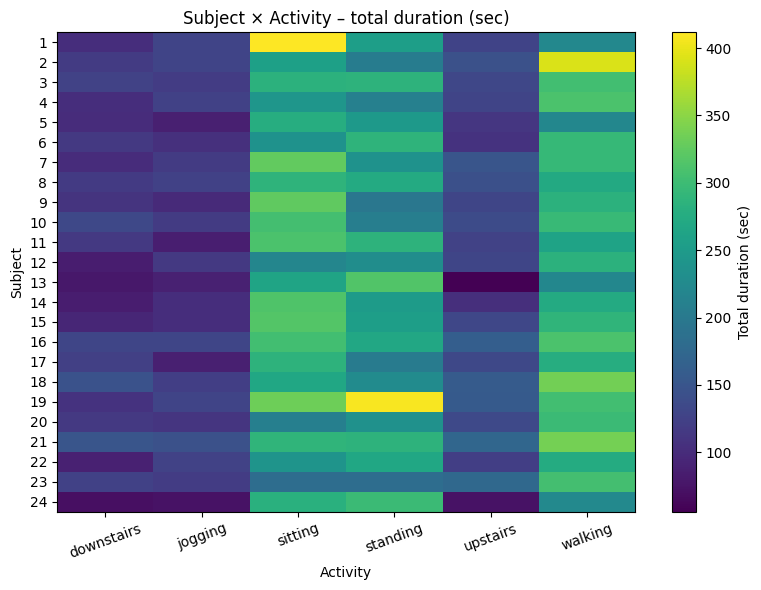

In [36]:
plt.figure(figsize=(8, 6))
plt.imshow(sub_act_dur, aspect="auto")
plt.colorbar(label="Total duration (sec)")
plt.xticks(range(len(sub_act_dur.columns)), sub_act_dur.columns, rotation=20)
plt.yticks(range(len(sub_act_dur.index)), sub_act_dur.index)
plt.title("Subject × Activity – total duration (sec)")
plt.xlabel("Activity")
plt.ylabel("Subject")
plt.tight_layout()
plt.show()